# 💻 📸 Understanding Computer Vision a Little Better 📸 💻

---
### **👀 Vision Transformers in Practice** 👀

#### Ambreen Hamadani







###**Our Task**: a **pre-trained Vision Transformer (ViT)** from Hugging Face's  Transformers library and fine-tuning it on a **Fashion Product Images dataset** for **image classification**




## **A Little Background First**

In [ ]:
from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1f2GHeFIzKvEuiSfACMeBFb5S4fCaVtMLR9rPLjpOqDY/preview" width="1000" height="800" allow="autoplay"></iframe>')

/usr/local/lib/python3.11/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


#**LET'S TAKE THIS STEP BY STEP!**

In [ ]:
#install the relevant libraries
!pip install -q transformers datasets
!pip install -U transformers
!pip install --upgrade datasets huggingface_hub

# **1. COLLECT DATA**

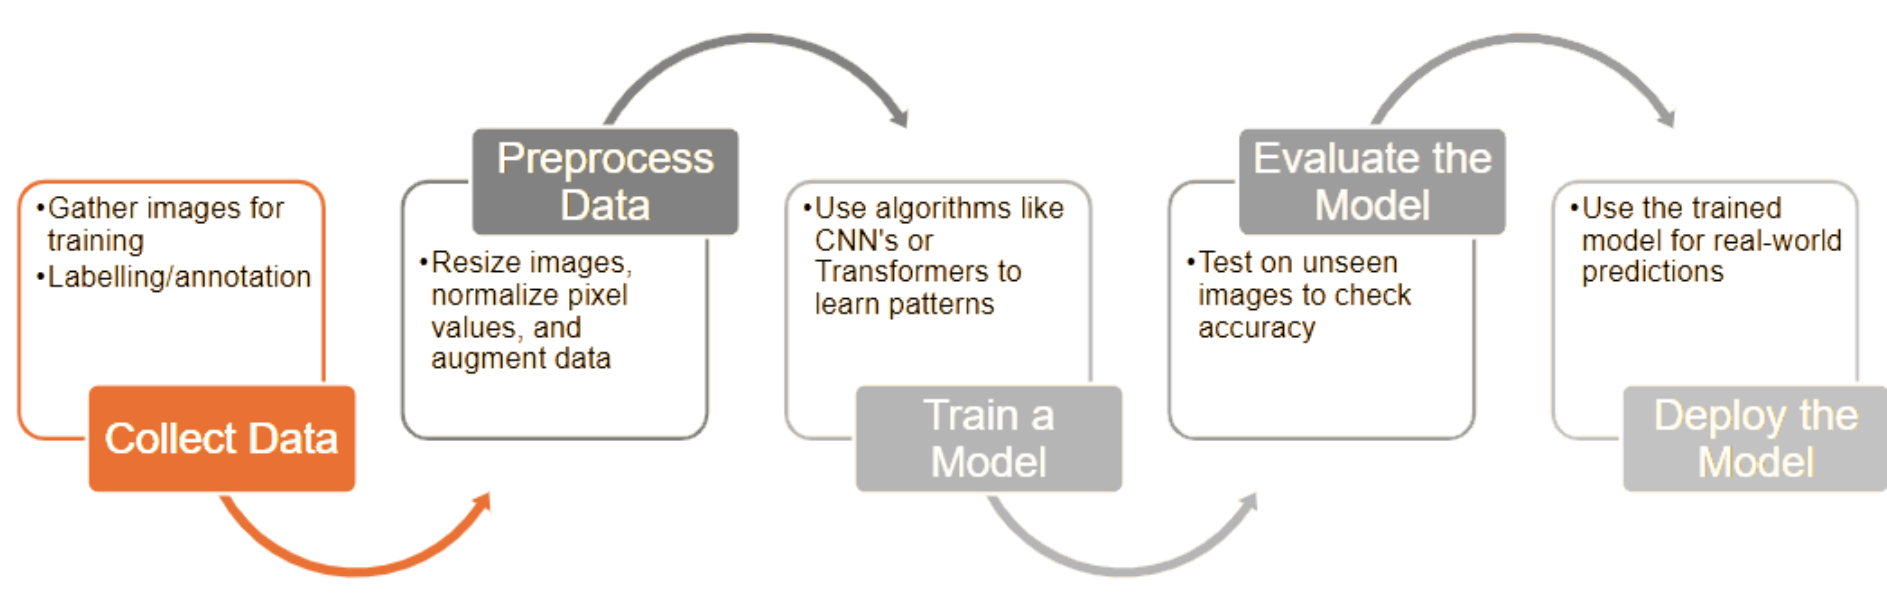

#1a. Import


In [ ]:
# Step 1: Restart runtime after this install, then run this next code:
import os
from datasets import load_dataset, DownloadConfig

# Step 2: Point cache and download dirs to /content
os.environ["HF_DATASETS_CACHE"] = "/content/hf_cache"
os.environ["HF_DATASETS_OFFLINE"] = "1"  # prevent it from auto-calling remote
os.environ["HF_DATASETS_ENABLE_SYSTEM_LOGGING"] = "0"

# Step 3: Force re-download and load with custom download config
download_config = DownloadConfig(cache_dir="/content/hf_cache")

data1 = load_dataset('ceyda/fashion-products-small',
                     cache_dir="/content/hf_cache",
                     download_config=download_config,
                     download_mode="force_redownload")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

(…)-00000-of-00002-357f4cbabe1a8ea6.parquet:   0%|          | 0.00/298M [00:00<?, ?B/s]

(…)-00001-of-00002-cbe936f1880f5e72.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42700 [00:00<?, ? examples/s]

In [ ]:
# 2) Make label mappings once, on the full set
ds =data1

#1b. Visualize

Repo card metadata block was not found. Setting CardData to empty.


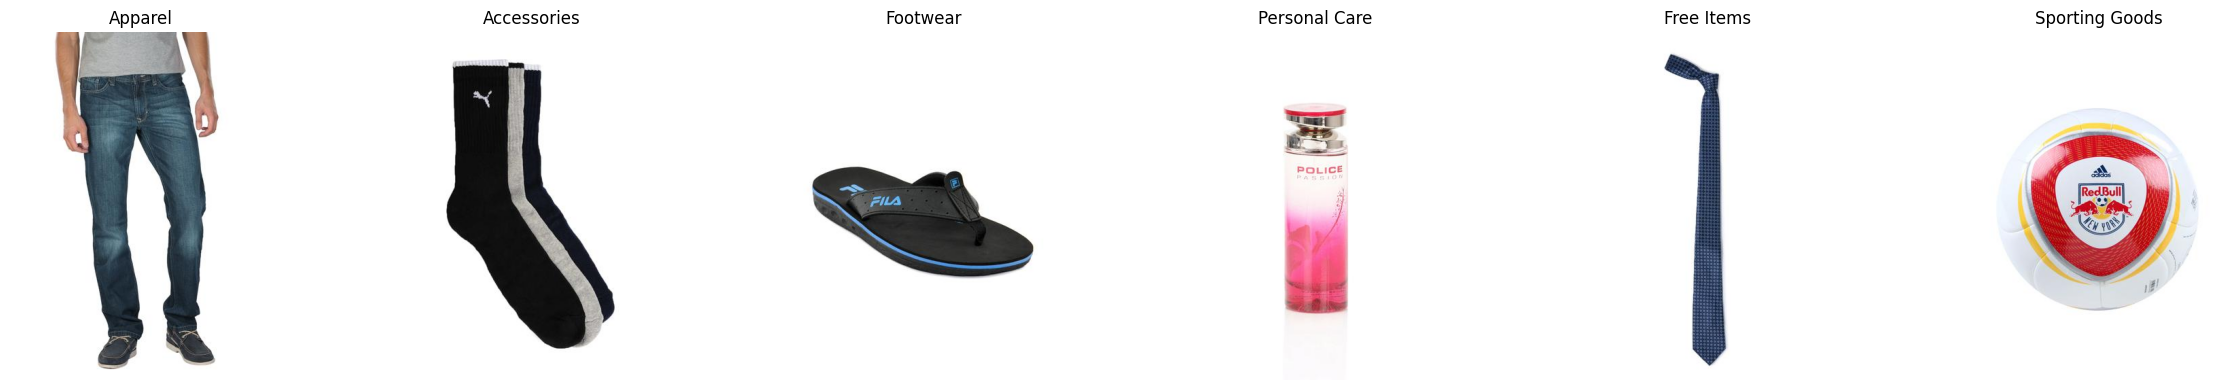

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load the dataset
dataset = load_dataset("ceyda/fashion-products-small", split="train")

# Keep only required columns
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ['masterCategory', 'image']])

# Collect the 2nd image per masterCategory
category_counts = {}
category_examples = {}

for item in dataset:
    cat = item['masterCategory']
    category_counts[cat] = category_counts.get(cat, 0) + 1

    # Store the second image (i.e., when count == 2)
    if category_counts[cat] == 2:
        category_examples[cat] = item

    if len(category_examples) >= 10:  # Early stop after 10 categories
        break

# Plot
n = len(category_examples)
plt.figure(figsize=(4 * n, 4))
for i, (cat, item) in enumerate(category_examples.items()):
    plt.subplot(1, n, i + 1)
    plt.imshow(item['image'])
    plt.title(f"{cat}")
    plt.axis('off')

plt.tight_layout()
plt.show()


---
___

#1c. Split into Training Data, Validation Data and Testing Data






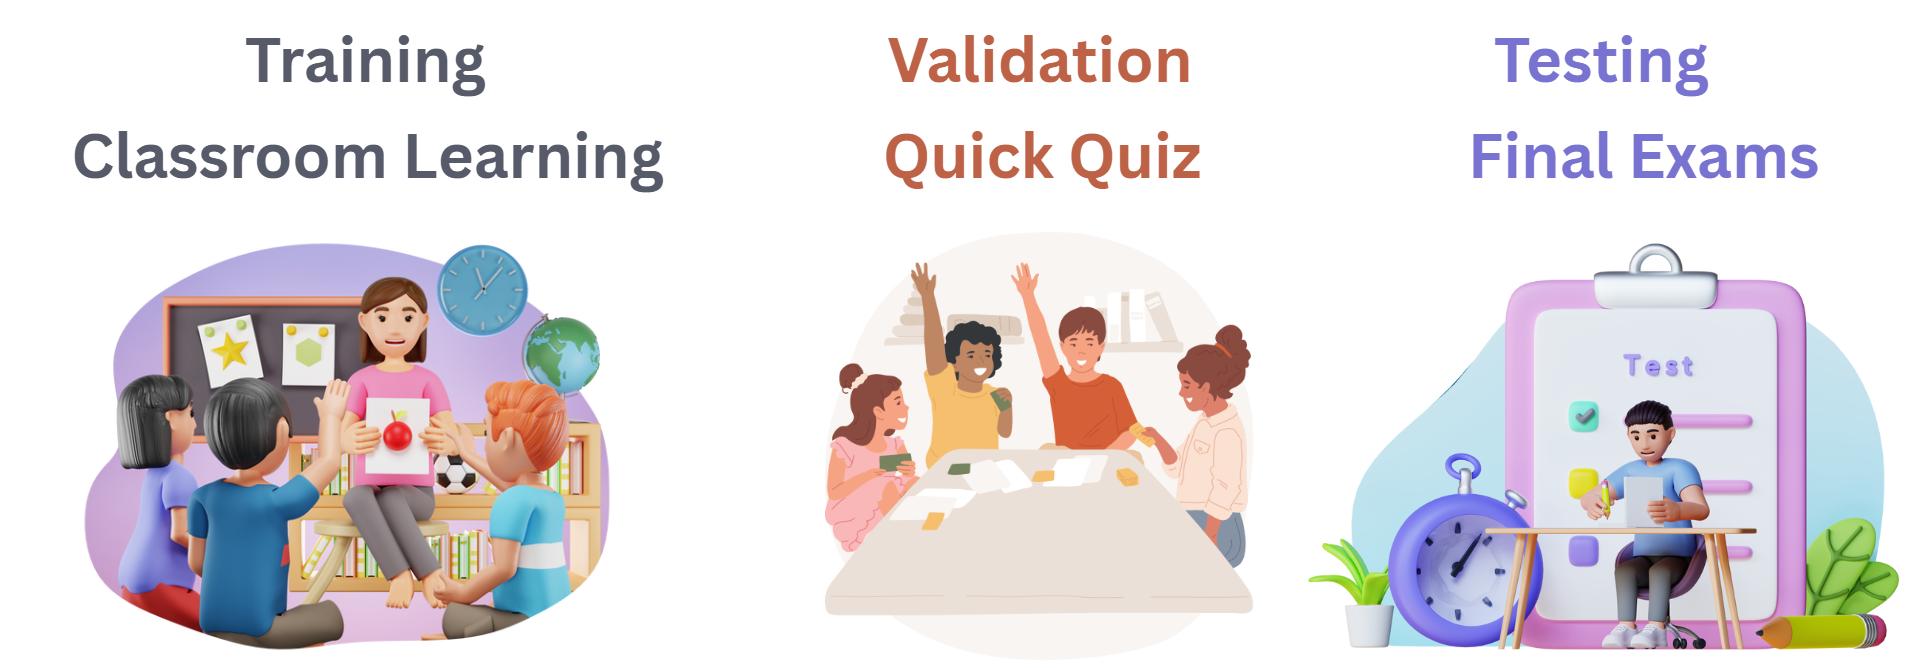


In [ ]:
# Split the dataset into train and validation (e.g., 80% train, 20% validation)
train_val_split = data1['train'].train_test_split(test_size=0.2, seed=42)

# Access the new splits
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

# Optional: Create a separate test split from the original data (e.g., 10% of total)
test_split = train_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = test_split['train']
test_dataset = test_split['test']

# Print the sizes of the splits
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 30744 samples
Validation dataset: 8540 samples
Test dataset: 3416 samples


In [ ]:
# Extract the 'train' and 'test' data
train_data = train_dataset
valid_data = val_dataset
test_data = test_dataset

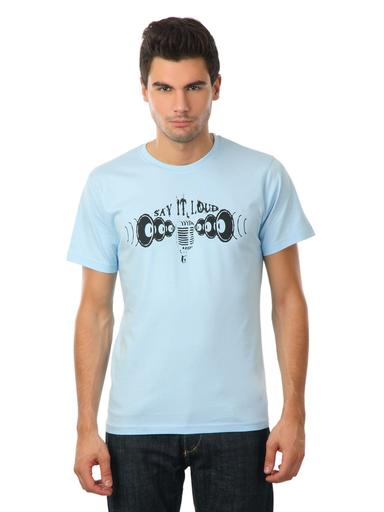

In [ ]:
train_data[200]['image']

In [ ]:
label = list(set(train_data['masterCategory']))
id2label = {id:label for id, label in enumerate(label)}
label2id = {label:id for id,label in id2label.items()}
print(id2label, label2id)

{0: 'Personal Care', 1: 'Free Items', 2: 'Footwear', 3: 'Accessories', 4: 'Apparel', 5: 'Sporting Goods', 6: 'Home'} {'Personal Care': 0, 'Free Items': 1, 'Footwear': 2, 'Accessories': 3, 'Apparel': 4, 'Sporting Goods': 5, 'Home': 6}


# 2. Preprocessing the data
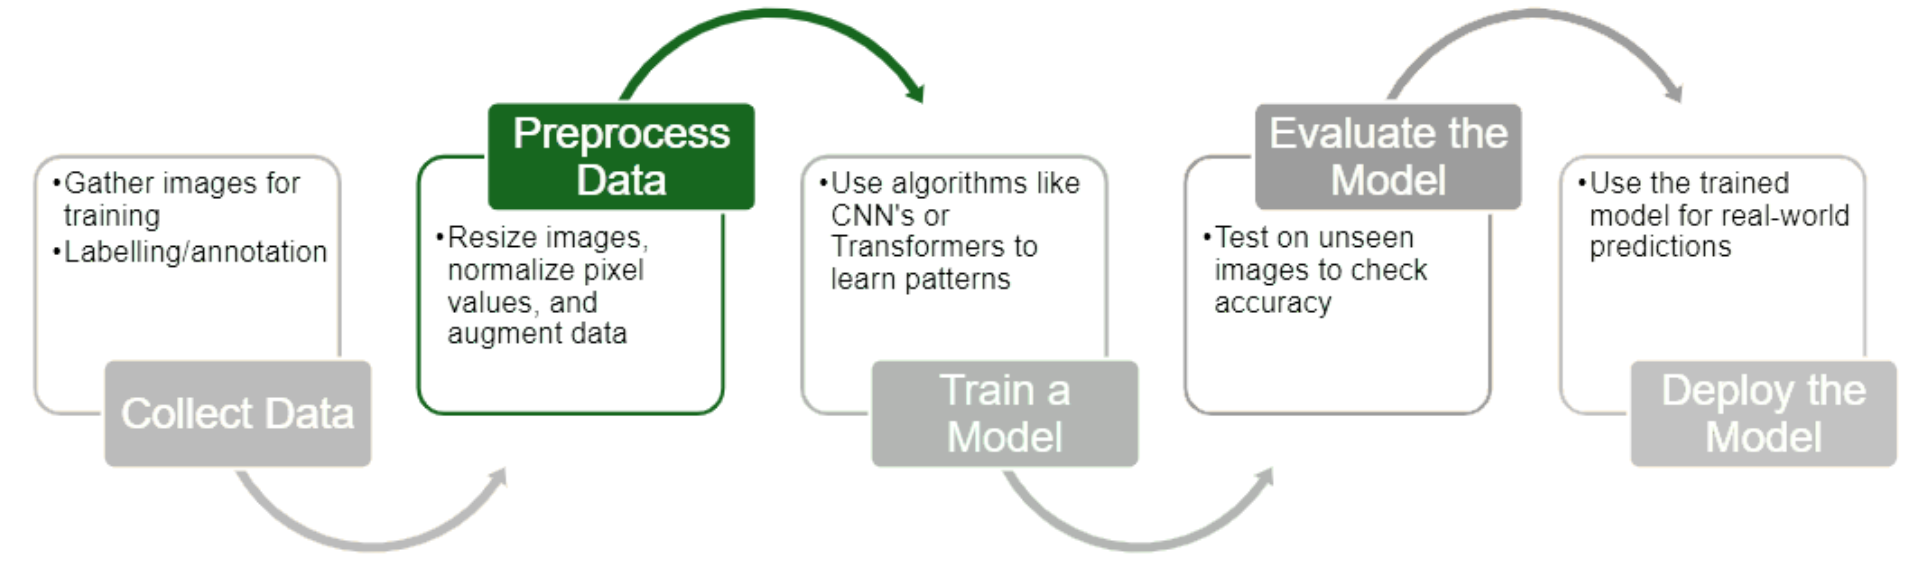



---
---
#2a. Import the pretrained model






In [ ]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

#2b Process your images exactly as the model expects

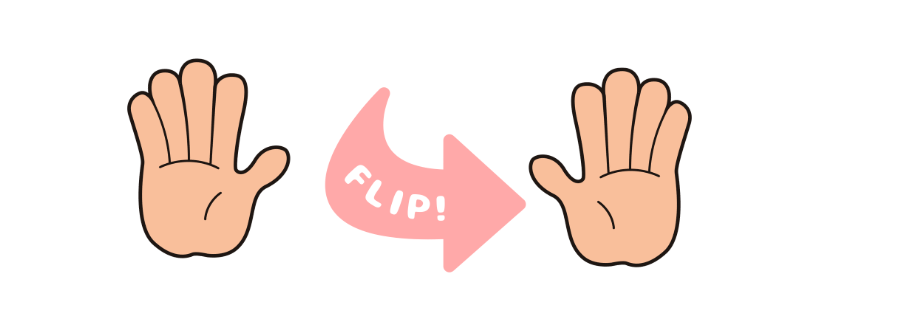

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            # CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [ ]:
# Set the transforms
train_data.set_transform(train_transforms)
# val_ds.set_transform(val_transforms)
test_data.set_transform(val_transforms)


#3. **TRAIN A MODEL**

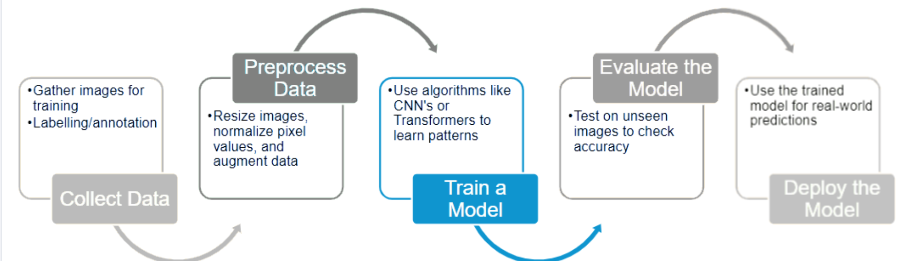

#3a. Create a DataLoader

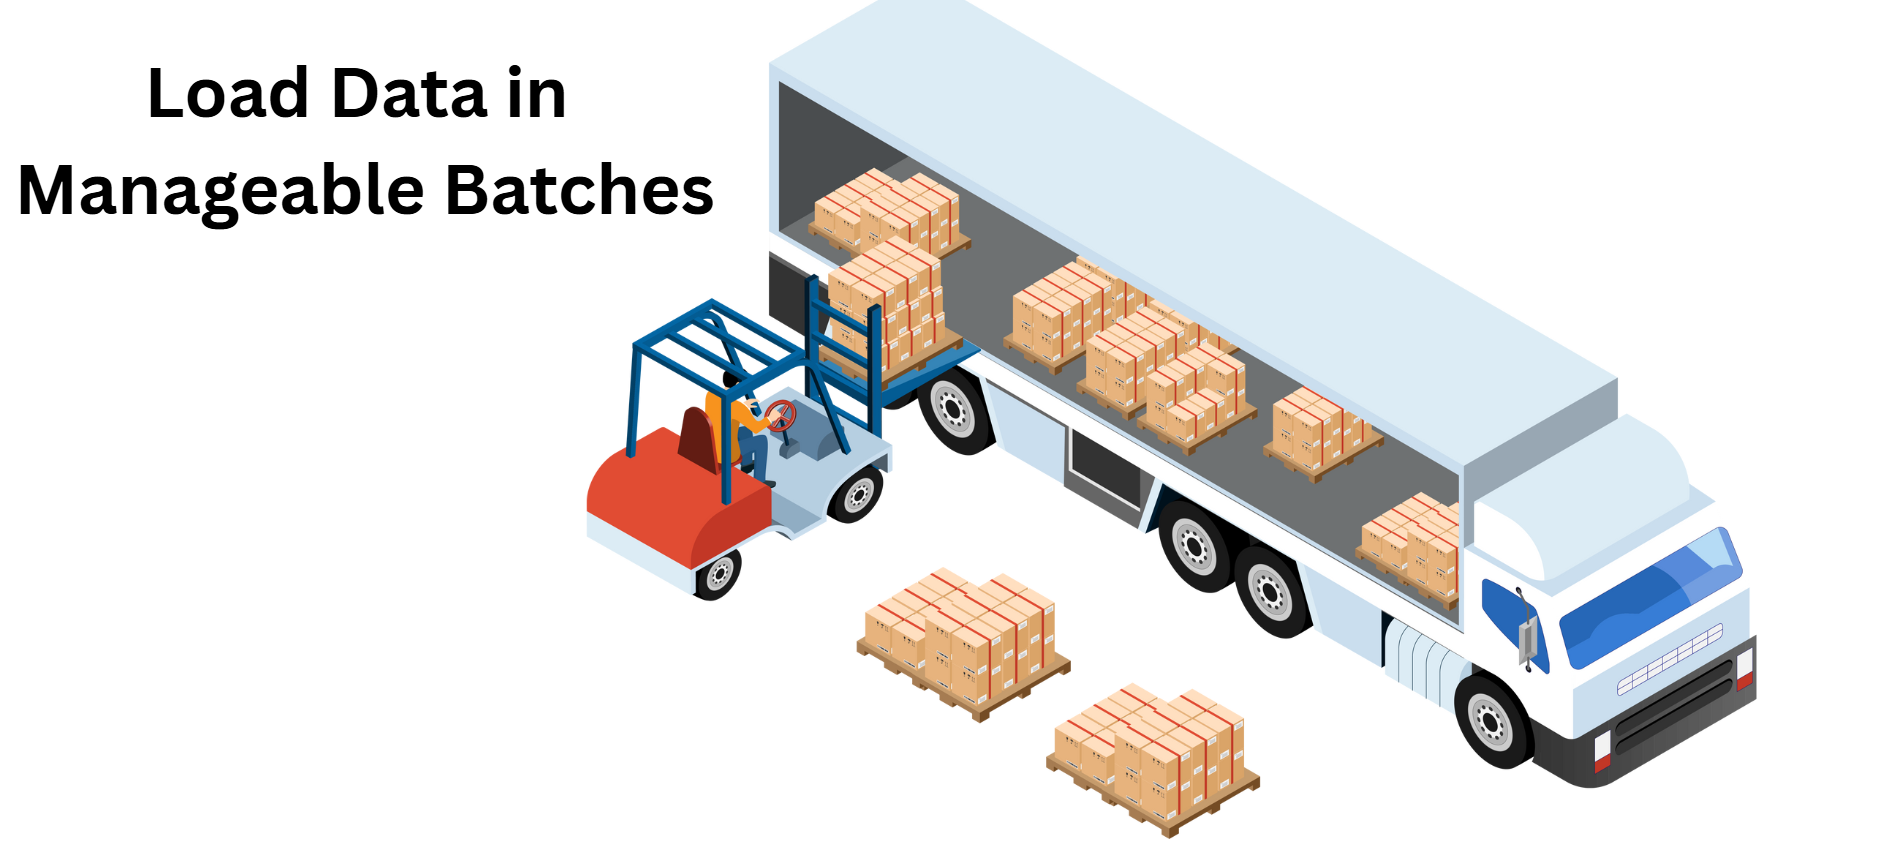

---
----
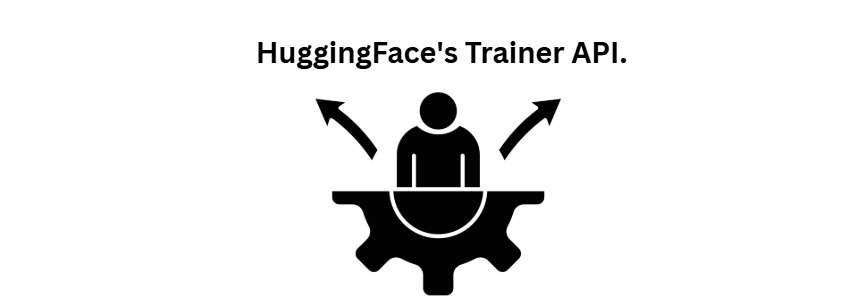

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["masterCategory"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_data, collate_fn=collate_fn, batch_size=4)

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(torch.device("cuda"))

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

# 3b. Instantiate a `Trainer` and Set the evaluation criteria
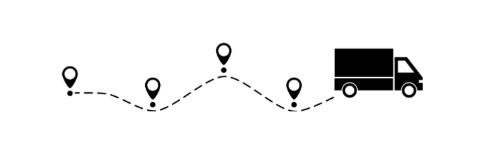

In [ ]:
from transformers import TrainingArguments

# Define training arguments
args = TrainingArguments(
    output_dir="Fashion-Product-Images",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    remove_unused_columns=False,
    report_to='none',

)

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
import torch
from transformers import Trainer # Import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

/tmp/ipython-input-20-3324219333.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#3c. Get set - Go!

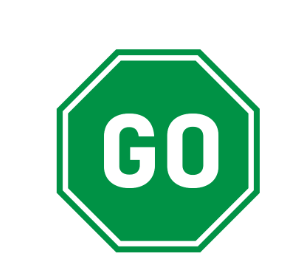

In [ ]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
import os
#os.environ["WANDB_DISABLED"] = "true"
trainer.train()

TrainOutput(global_step=1922, training_loss=0.08786899118095977, metrics={'train_runtime': 1183.8034, 'train_samples_per_second': 25.971, 'train_steps_per_second': 1.624, 'total_flos': 2.3825204928144507e+18, 'train_loss': 0.08786899118095977, 'epoch': 1.0})

#4. Evaluation

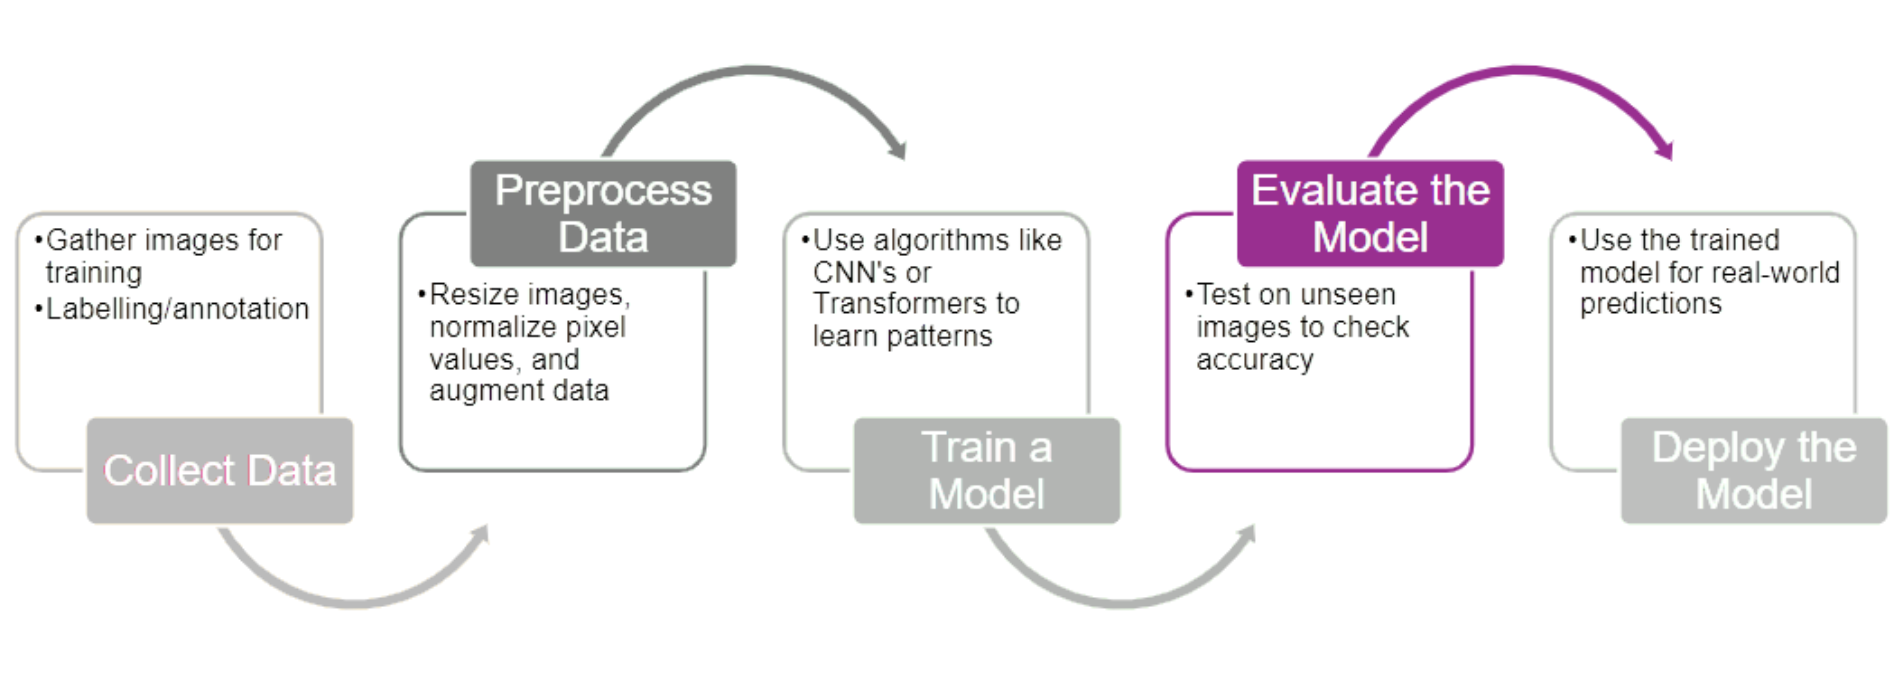

In [ ]:
outputs = trainer.predict(test_data)

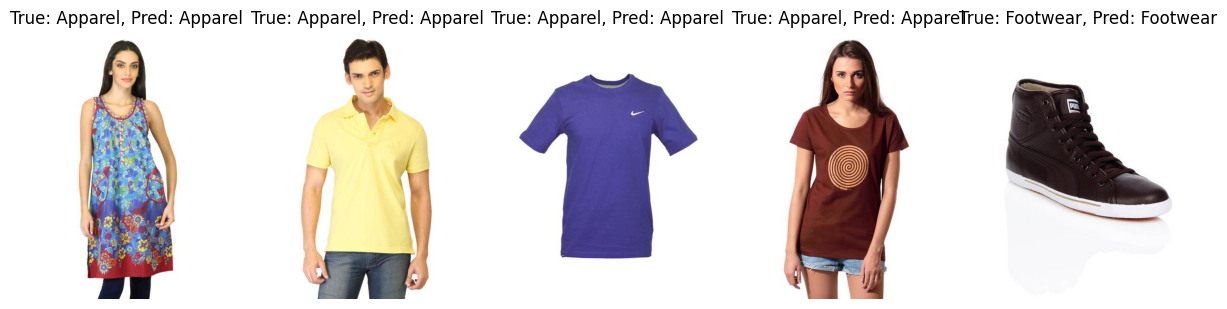

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

# Run predictions on the test data
#outputs = trainer.predict(test_data)

# Extract the predictions (logits) and convert them to labels
predictions = np.argmax(outputs.predictions, axis=1)

# Display some images with their predicted labels
num_images = 5  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    # Get image and label
    img = test_data[i]['image']  # Assuming 'image' is the key containing the image
    img_label = test_data[i]['masterCategory']  # Ground truth label (if available)
    pred_label_idx = predictions[i]  # Predicted label (index)
    pred_label = id2label.get(pred_label_idx, "Unknown")  # Map the index to label

    # If the image is a tensor, convert it to numpy array
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  # Change the shape from (C, H, W) to (H, W, C)

    # Convert from float32 to uint8
    img = np.clip(img, 0, 255).astype('uint8')

    # Convert the numpy array to a PIL Image
    img = Image.fromarray(img)

    # Show the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"True: {img_label}, Pred: {pred_label}")  # Display true and predicted label


plt.show()


# **5. DEPLOY THE MODEL**

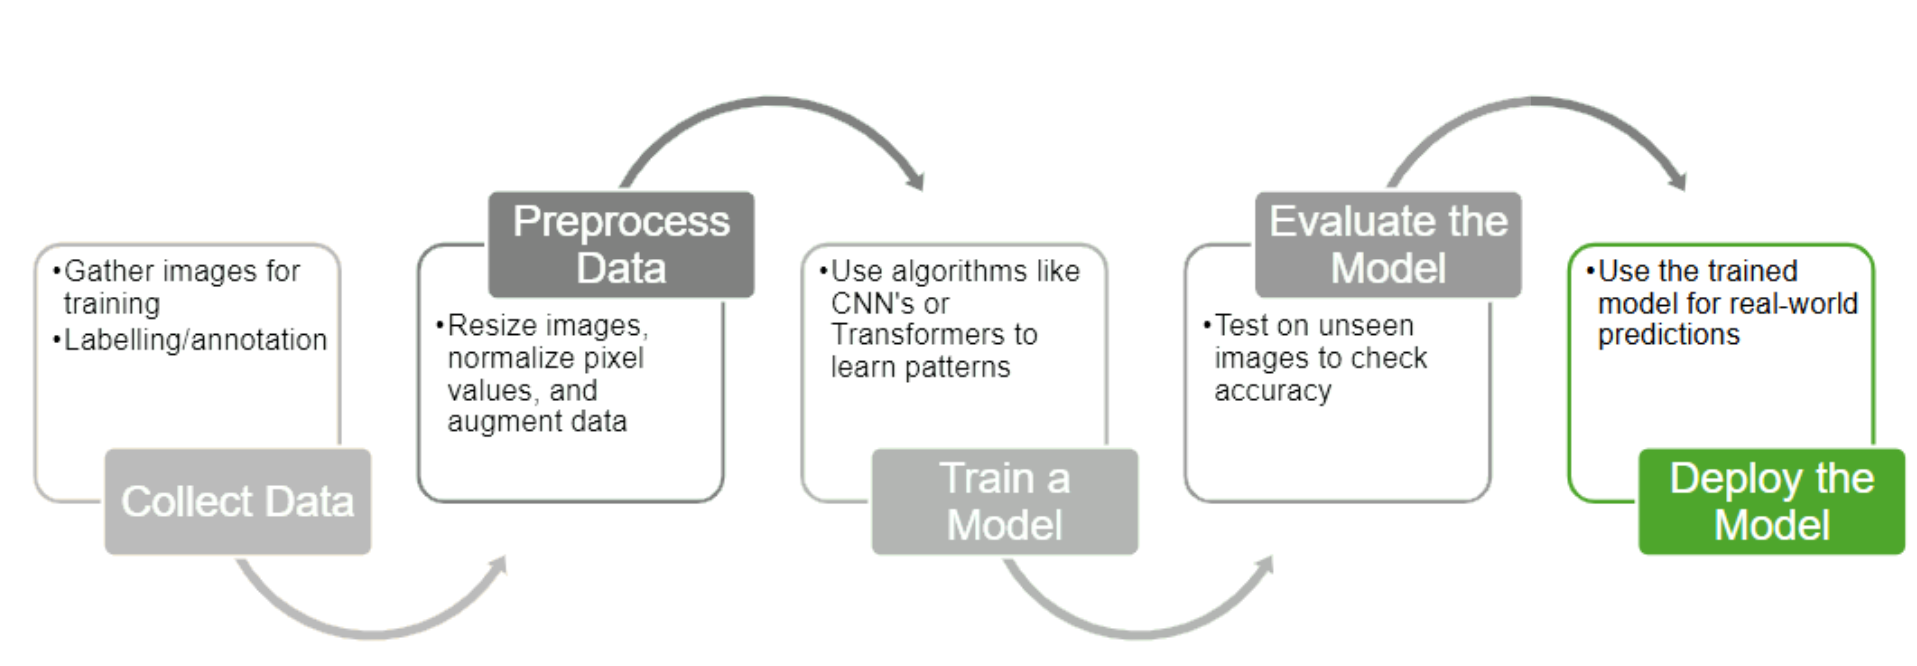

#5. Save

In [ ]:
# Save the model's state dict
torch.save(model.state_dict(), 'vision_transformer_model.pth')

#5.b Deploy as an app or website


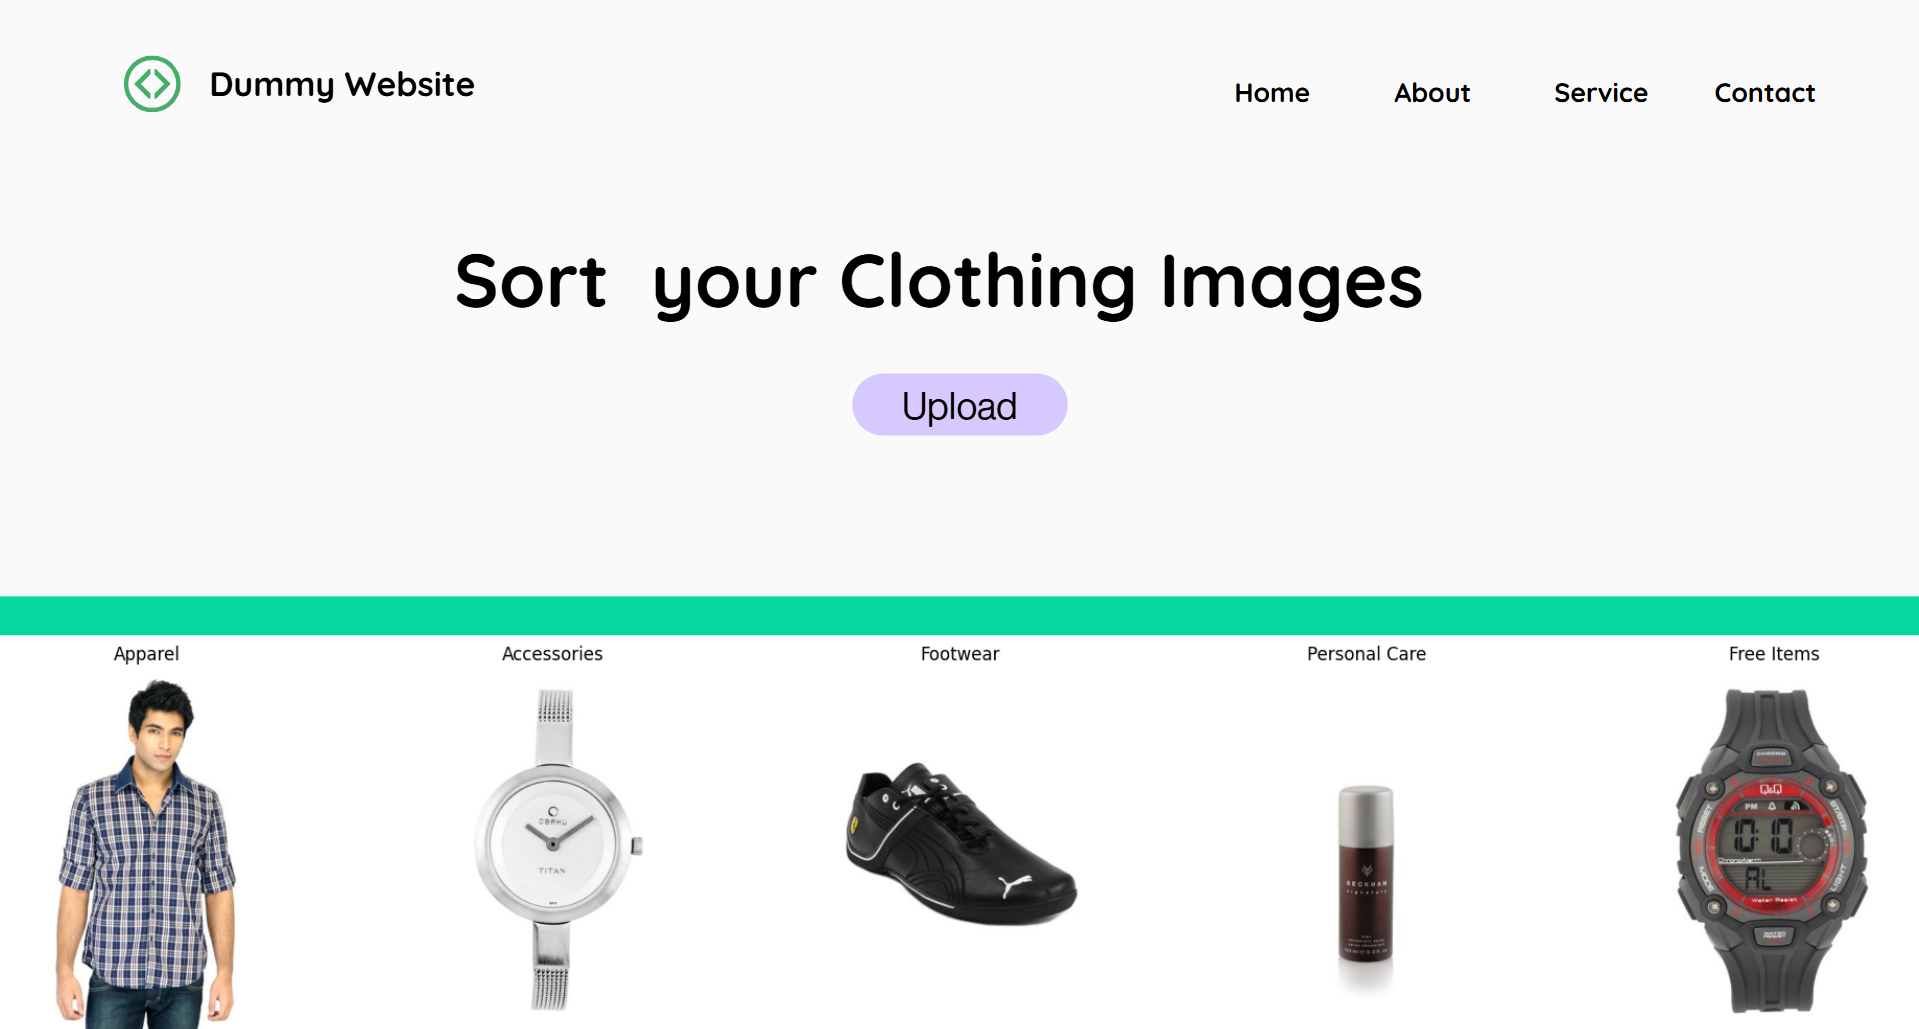

# **Impotance in literature review?**
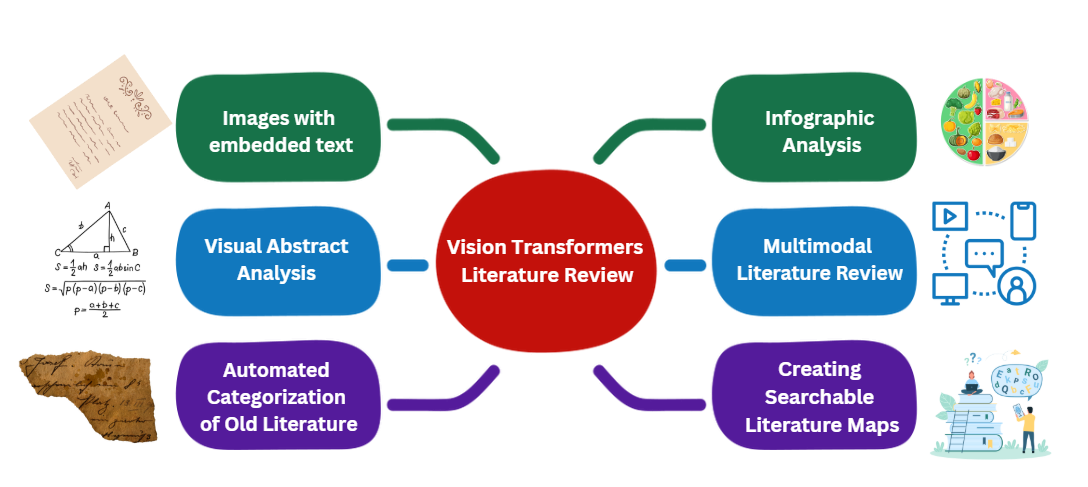

## Simplest Example
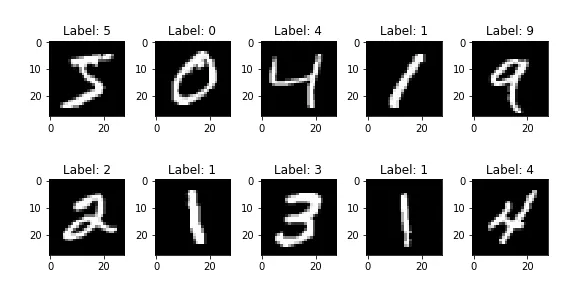

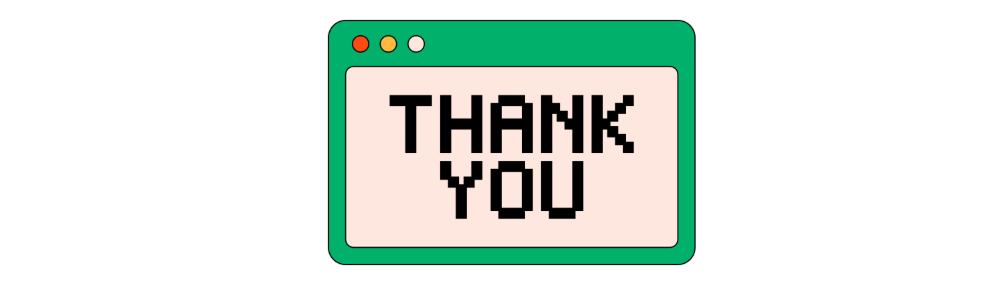

____
____